In [1]:
import torch

In [2]:
import diffusers

In [3]:
from diffusers import VQModel

/home/gagan/anaconda3/envs/birdsonggan/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/gagan/anaconda3/envs/birdsonggan/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# Test VQModeL

In [8]:
model = VQModel(in_channels=1, out_channels=1, latent_channels=1, vq_embed_dim=512, num_vq_embeddings=1000, layers_per_block=3)

In [9]:
model.device

device(type='cpu')

In [5]:
x = torch.rand(32,1,129,16)
x.shape

torch.Size([32, 1, 129, 16])

In [14]:
print(x.min(), x.max())

tensor(1.4961e-05) tensor(1.0000)


In [10]:
#with torch.no_grad():
ze = model.encode(x)
zq, commloss, (_, _, min_encoding_indices) = model.quantize(ze.latents)
# recon loss
xhat = model.decode(zq).sample

In [11]:
zq.shape

torch.Size([32, 512, 129, 16])

In [12]:
ze.keys()

odict_keys(['latents'])

In [15]:
print(xhat.min(), xhat.max())

tensor(-1.5780, grad_fn=<MinBackward1>) tensor(1.6679, grad_fn=<MaxBackward1>)


In [33]:
e = vq.quantize(h.latents)

In [42]:
e[0].shape

torch.Size([32, 512, 129, 16])

In [43]:
e[0].dtype

torch.float32

In [46]:
e[1]

tensor(0.4473, grad_fn=<AddBackward0>)

In [45]:
e[-1]

(None, None, tensor([68, 68, 68,  ..., 68, 68, 68]))

In [51]:
c = vq.quantize.get_codebook_entry(indices=torch.LongTensor([68,102,220]), shape=None)

In [52]:
c.shape

torch.Size([3, 512])

In [98]:
vq.quantize.legacy = False
vq.quantize.beta = 95 / 5

# load dataset

In [1]:
from datasets import load_from_disk
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ds = load_from_disk("/media/gagan/Gagan_external/songbird_data/age_resampled_hfdataset/")

In [3]:
len(ds)

514229

In [4]:
x = np.array(ds[0]["spectrogram"])
x.shape

(129, 250)

In [5]:
from birdsong_gan.train.train_vqvae import SpectrogramSnippets

/home/gagan/anaconda3/envs/birdsonggan/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/gagan/anaconda3/envs/birdsonggan/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [6]:
dataset = SpectrogramSnippets(ds, log_scale=True)

In [9]:
x = torch.stack([dataset[i] for i in range(200)])
x.shape

torch.Size([200, 1, 129, 16])

In [10]:
y = torch.stack([dataset[i] for i in range(200, 400)])
y.shape

torch.Size([200, 1, 129, 16])

In [16]:
from birdsong_gan.utils.audio_utils import plot_spectrogram

In [ ]:
_ = plot_spectrogram(x, figsize=(15,5))

In [11]:
from birdsong_gan.train.train_vqvae import plot_reconstruction_and_original

In [16]:
plot_reconstruction_and_original(x, x, 0, 1, ".", figsize=(20,6))

# Create train-test split

In [3]:
ds = ds.train_test_split(test_size=0.05)
train_ds = ds["train"]
test_ds = ds["test"]

In [ ]:
train_ds.save_to_disk("/media/gagan/Gagan_external/songbird_data/age_resampled_hfdataset/train")

Saving the dataset (0/212 shards):   0%|          | 0/488517 [00:00<?, ? examples/s]

In [6]:
test_ds.save_to_disk("/media/gagan/Gagan_external/songbird_data/age_resampled_hfdataset/test")

Saving the dataset (0/12 shards):   0%|          | 0/25712 [00:00<?, ? examples/s]

# Test learned network

In [92]:
import torchaudio
import os
import torch
from datasets import load_from_disk
import numpy as np

In [93]:
from birdsong_gan.train.train_vqvae import VQVAEModel, VQModel, TrainingConfig
import json

In [3]:
model_dir = "/home/gagan/ek_experiments/vqvae/2024-02-10_10-29-46/"

In [10]:
with open(os.path.join(model_dir, "experiment_config.json"), "r") as f:
    config = json.load(f)

In [6]:
type(config)

dict

In [11]:
cfg = TrainingConfig()
cfg.from_dict(config)

In [8]:
def load_model_from_checkpoint(config):
    # create model
    vq = VQModel(
        in_channels=1,
        out_channels=1,
        latent_channels=1,
        num_vq_embeddings=config.num_vq_embeddings,
        vq_embed_dim=config.vq_embed_dim,
        layers_per_block=config.layers_per_block,
        sample_size=config.batch_size,
    )
    num_params = vq.num_parameters()
    print(f"Number of parameters in model: {num_params}")

    vq.quantize.legacy = False  # use new quantize function
    vq.quantize.beta = config.vq_beta

    model = VQVAEModel(vq)
    if config.last_checkpoint_path is not None:
        model.load_state_dict(torch.load(config.last_checkpoint_path))
    model.to(config.device)
    return model.eval()

In [13]:
cfg.last_checkpoint_path = os.path.join(model_dir, "model_checkpoint_3_1999.pt")

In [16]:
model = load_model_from_checkpoint(cfg)

Number of parameters in model: 855651


In [17]:
model.vq.device

device(type='cuda', index=0)

## load dataset

In [18]:
ds = load_from_disk(cfg.dataset_path)
len(ds)

514229

In [19]:
from birdsong_gan.train.train_vqvae import SpectrogramSnippets

In [20]:
dataset = SpectrogramSnippets(ds)

In [30]:
def preprocess_example(x, device: str = "cuda"):
    x = np.array(x["spectrogram"])
    x = np.log1p(x)
    return torch.from_numpy(x).to(torch.float32).to(device)

In [23]:
from birdsong_gan.data.data_utils import get_random_sample

In [31]:
x = get_random_sample(ds, seed=100)
x = preprocess_example(x)
x.shape


torch.Size([129, 152])

In [34]:
xt = []
i = 0
for t in range(x.shape[-1] // 16):
    xt.append(x[:, i : i + 16].unsqueeze(0))
    i += 16
xt = torch.stack(xt)
xt.shape

torch.Size([9, 1, 129, 16])

## inference

In [38]:
model.vq.quantize.sane_index_shape = True

In [39]:
codes = model.infer_latent_code(xt)
codes.shape

torch.Size([9, 129, 16])

In [77]:
xhat = model.reconstruct(xt)
xhat.shape

torch.Size([9, 1, 129, 16])

In [78]:
# xhat = torch.exp(xhat).squeeze() - 1
xhat = xhat.squeeze().cpu()
xhat.min()

tensor(0.)

In [79]:
xhat = torch.cat([y for y in xhat], dim=-1)
xhat.shape

torch.Size([129, 144])

In [83]:
glm = torchaudio.transforms.GriffinLim(n_fft=256, n_iter=200, power=1.)

In [84]:
audio = glm(xhat)
audio.shape

torch.Size([18304])

In [85]:
torchaudio.save("./test.wav", audio.unsqueeze(0), 16000, channels_first=True)

In [86]:
x.shape

torch.Size([129, 152])

In [90]:
orig_audio = glm(x.cpu())
orig_audio.shape

torch.Size([19328])

In [91]:
torchaudio.save("./test2.wav", orig_audio.unsqueeze(0), 16000, channels_first=True)

In [67]:
from birdsong_gan.utils.audio_utils import plot_spectrogram

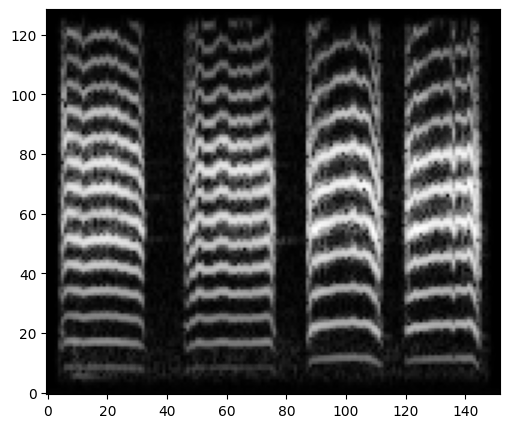

In [69]:
ff = plot_spectrogram(x.cpu().numpy(), (12,5))

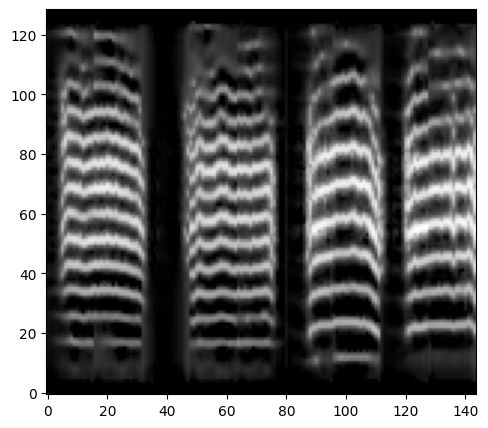

In [80]:
ff = plot_spectrogram(xhat.cpu().numpy(), (12,5))

# Adding downsampling and upsampling layers to encoder

In [1]:
import torch
from diffusers.models.unets.unet_2d_blocks import DownBlock2D, Downsample2D, Upsample2D

/home/gagan/anaconda3/envs/birdsonggan/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [13]:
dsample = torch.nn.Sequential(Downsample2D(channels=1, use_conv=True, out_channels=1, kernel_size=3, padding=0),
                              #Downsample2D(channels=1, use_conv=True, out_channels=1, kernel_size=3, padding=0),
                              #Downsample2D(channels=1, use_conv=True, out_channels=1, kernel_size=3, padding=0),
                             )

In [14]:
usample = torch.nn.Sequential(Upsample2D(channels=1, use_conv=True, out_channels=1, kernel_size=3, padding=1),
                              #Upsample2D(channels=1, use_conv=True, out_channels=1, kernel_size=3, padding=1),
                              #Upsample2D(channels=1, use_conv=True, out_channels=1, kernel_size=3, padding=1),
                              )

In [15]:
x = torch.rand(10, 1, 129, 16)

In [16]:
with torch.no_grad():
    o = dsample(x)
o.shape

torch.Size([10, 1, 64, 8])

In [17]:
with torch.no_grad():
    x = usample(o)
x.shape

torch.Size([10, 1, 128, 16])

In [18]:
x = torch.nn.functional.pad(x, pad=(0, 0, 1, 0))
x.shape

torch.Size([10, 1, 129, 16])

# Discriminator based training

In [ ]:
from birdsong_gan.models.nets_16col_residual import _netD


class Discriminator(torch.nn.Module):

    def __init__(self, num_discriminator_multiplier: int = 32):
        super().__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(nc, ndf, kernel_size=4, stride=(2,2), padding=(1,1), bias=False),
            # size H = (129 +2 -4)/2 + 1 = 64, W = (16 +2 -4)/2 + 1 = 8
            nn.Conv2d(ndf, ndf * 2, kernel_size=(4, 3), stride=(2, 1), padding=(1, 0), bias=False),
            # size H = (64 +2 -4)/2 + 1 = 32, W = (8 -3) + 1 = 6
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=(4,3), stride=(2,1), padding=(2,0), bias=False),
            # size H = (32 +4 -4)/2 + 1 = 17, W = (6 -3) + 1 = 4
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=(8,4), stride=(2,1), padding=1, bias=False),
            # H = (17 +2 -8)/2 + 1 = 6, W = (4 +2 -4) + 1 = 3
            nn.Conv2d(ndf * 8, 1, kernel_size=(6,3), stride=1, padding=0, bias=False),
            # H = 6-6 + 1 =1, W = (4 - 3) +1 =  
        ])
        self.lns = nn.ModuleList([nn.LayerNorm([ndf, 64, 8]),
                                  nn.LayerNorm([ndf * 2, 32, 6]),
                                  nn.LayerNorm([ndf * 4, 17, 4]),
                                  nn.LayerNorm([ndf * 8, 6, 3])])
        self.activations = nn.ModuleList([nn.LeakyReLU(0.2),nn.LeakyReLU(0.2),
                                    nn.LeakyReLU(0.2),nn.LeakyReLU(0.2)])
        
        self.loss = torch.nn.BCEWithLogitsLoss()
        
    def true_wp(self, prob, size):
        # generate a uniform random number
        p = torch.rand(size).to(self.device).float()
        # if prob = 0.9, most of the time, this will be True
        p = (p < prob).float()
        return p 

    def forward(self, x: torch.Tensor, label: str = "real") -> torch.Tensor:
        for i in range(4):
            x = self.convs[i](x)
            x = self.lns[i](x)
            x = self.activations[i](x)
            x = self.convs[-1](x)
        x = x.view(-1, 1) # flatten

        if label == "real":
            
        return self.loss(